In [1]:
import cudf 
import cupy as cp
cp.random.seed(0)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def change_dates(df):
    #changes fecha_inicio_sintomas according to new criteria
    filt_df2 = (df.fecha_inicio_sintomas.isnull()) #filter fecha_inicio_sintomas = inexistant
    n_size = (df[filt_df2]).shape[0]
    df["fecha_inicio_sintomas"] = df["fecha_inicio_sintomas"].fillna(0)
    df["fecha_inicio_sintomas"] = df["fecha_inicio_sintomas"].astype('int')
    df["fecha_apertura"] = df["fecha_apertura"].astype('int')
    b = cp.array(df["fecha_apertura"].values)
    a = cp.array(df["fecha_inicio_sintomas"].values)
    a[filt_df2.values] = b[filt_df2.values] - cp.random.randint(0,9,a[filt_df2.values].shape)
    filt_a = cp.where(a<0)
    a[filt_a] = 0
    df = df.drop(["fecha_inicio_sintomas"],axis=1)
    df["fecha_inicio_sintomas"] = a
    return df

## Carga de datos, sacamos las series temporal

In [4]:
direccion = '12en20.csv'
columnas = ['residencia_provincia_nombre','residencia_departamento_nombre','fecha_inicio_sintomas',
            'fecha_apertura','clasificacion_resumen']
data = cudf.read_csv(direccion,sep=",",quotechar='"', usecols=columnas,
                   parse_dates=["fecha_inicio_sintomas","fecha_apertura"],na_values=['']) 

In [5]:
data = data[data["clasificacion_resumen"] == "Confirmado"] #filter confirmed cases
df = cudf.DataFrame(data) 

In [6]:
df = df.drop(['clasificacion_resumen'], axis=1) #drop clasificacion_resumen bc previous filter of confirmed cases

In [7]:
filt_df1 = (df.fecha_inicio_sintomas.notnull()) #filter fecha_inicio_sintomas = inexistant
inicio_epidemia = (df.loc[filt_df1,"fecha_inicio_sintomas"]).min() #first symptoms of a person registered
ultima_actualizacion_sintomas = (df.loc[filt_df1,"fecha_inicio_sintomas"]).max() #last day symptoms of a person registered
ultima_actualizacion_apertura = (df["fecha_apertura"]).max()
df["fecha_inicio_sintomas"] -= inicio_epidemia #correcting by inicio_epidemia 
df["fecha_apertura"] -= inicio_epidemia #correcting by inicio_epidemia
df.fecha_inicio_sintomas = df.fecha_inicio_sintomas.dt.days #change to int, ditch days 
df.fecha_apertura = df.fecha_apertura.dt.days #change to int, ditch days
print("primer sintoma de persona confirmada: ",inicio_epidemia)
print("ultimo sintoma de persona confirmada: ",ultima_actualizacion_sintomas)
print("ultima apertura de persona confirmada: ",ultima_actualizacion_apertura)

primer sintoma de persona confirmada:  2020-01-01T00:00:00.000000000
ultimo sintoma de persona confirmada:  2021-01-11T00:00:00.000000000
ultima apertura de persona confirmada:  2021-01-11T00:00:00.000000000


In [8]:
df = change_dates(df) # we have replaced all bad or undefined dates

In [9]:
#let's list all the provinces that have cases (all rn tbh, but just to use pandas stuff)
#we'll get those times series then, with cudf grouping
provincias = df["residencia_departamento_nombre"].unique()
#print: we get provinces + the sin especificar / unespecified thing
print(provincias)

0      12 de Octubre
1         1º de Mayo
2         2 de Abril
3         25 de Mayo
4         9 de Julio
           ...      
442           Zapala
443            Zonda
444           Zárate
445        Ñorquincó
446          Ñorquín
Name: residencia_departamento_nombre, Length: 447, dtype: object


In [10]:
df = df[["residencia_departamento_nombre","fecha_inicio_sintomas"]]
df2 = df.groupby(["residencia_departamento_nombre","fecha_inicio_sintomas"]).size().reset_index() 
df2 = df2.rename(columns={0:'casos'})
df3 = df2.sort_values(["residencia_departamento_nombre","fecha_inicio_sintomas"],ascending=[True,True])

/home/denise/miniconda3/envs/gpup/lib/python3.7/site-packages/cudf/core/frame.py:2627: UserWarning: When using a sequence of booleans for `ascending`, `na_position` flag is not yet supported and defaults to treating nulls as greater than all numbers
  "When using a sequence of booleans for `ascending`, "


In [11]:
rows = provincias.shape[0]
cols = df2["fecha_inicio_sintomas"].max()
time_series = cp.zeros(shape=(rows,cols))
time_series_ac = cp.zeros(shape=(rows,cols))

In [12]:
j = 0
for i in provincias.to_pandas():
  df_tmp = df3[df3["residencia_departamento_nombre"]==i]
  tmp_dates = cp.array(df_tmp["fecha_inicio_sintomas"].values)
  tmp_cases = cp.array(df_tmp["casos"].values)
  time_series[j,tmp_dates]= tmp_cases
  j = j + 1

In [13]:
for i in range(rows):
  for j in range(13,cols):
    time_series_ac[i,j] = cp.sum(time_series[i,j-13:j+1])

In [14]:
time_series_ac

array([[  0.,   0.,   0., ...,  33.,  28.,  22.],
       [  0.,   0.,   0., ...,  10.,   8.,   8.],
       [  0.,   0.,   0., ...,   3.,   3.,   2.],
       ...,
       [  0.,   0.,   0., ..., 197., 178., 163.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ..., 109., 100.,  85.]])

## Primero, aca vamos a calcular la correlacion de Pearson y chequear que de todo bien

Esto funciona aca y esta todo tranquilo, no hay problema!

In [15]:
#no existe en cupy, la hago yo a esta funcion 
def pearsonr(a,b):
  m_a = cp.mean(a)
  m_b = cp.mean(b)
  r_a = a - m_a
  r_b = b - m_b
  r_a_2 = cp.sum((r_a)**2) 
  r_b_2 = cp.sum((r_b)**2)
  r = cp.sum((r_a*r_b)/cp.sqrt(r_a_2*r_b_2))
  return r

In [16]:
#por ejemplo, correlaciones para caba y baires
caba = time_series_ac[1,:-10]
baires = time_series_ac[0,:-10]
pearsonr(caba,baires)

array(0.37532676)

In [17]:
#ahora, tratemos de hacer lo mismo para baires y el resto del país
baires = time_series_ac[0,:-10]
i = 1
provs = provincias.to_pandas()
print('Coeficientes de Pearson')
while i < rows:
  prov_tmp = time_series_ac[i,:-10]
  r = pearsonr(baires,prov_tmp)
  print('Pearson entre '+provs[i]+' y Baires: ',cp.around(r,3))
  i += 1

Coeficientes de Pearson
Pearson entre 1º de Mayo y Baires:  0.375
Pearson entre 2 de Abril y Baires:  0.722
Pearson entre 25 de Mayo y Baires:  0.611
Pearson entre 9 de Julio y Baires:  0.919
Pearson entre Adolfo Alsina y Baires:  0.629
Pearson entre Adolfo Gonzales Chaves y Baires:  0.724
Pearson entre Aguirre y Baires:  0.488
Pearson entre Albardón y Baires:  0.826
Pearson entre Alberdi y Baires:  0.157
Pearson entre Alberti y Baires:  0.823
Pearson entre Almirante Brown y Baires:  0.141
Pearson entre Aluminé y Baires:  0.864
Pearson entre Ambato y Baires:  0.397
Pearson entre Ancasti y Baires:  0.3
Pearson entre Andalgalá y Baires:  0.463
Pearson entre Angaco y Baires:  0.773
Pearson entre Anta y Baires:  0.618
Pearson entre Antofagasta de la Sierra y Baires:  0.067
Pearson entre Antártida Argentina y Baires:  0.387
Pearson entre Apóstoles y Baires:  0.645
Pearson entre Arauco y Baires:  0.284
Pearson entre Arrecifes y Baires:  0.42
Pearson entre Atamisqui y Baires:  0.393
Pearson e

Pearson entre La Caldera y Baires:  0.174
Pearson entre La Candelaria y Baires:  0.556
Pearson entre La Capital y Baires:  0.775
Pearson entre La Cocha y Baires:  0.683
Pearson entre La Costa y Baires:  0.63
Pearson entre La Matanza y Baires:  0.056
Pearson entre La Paz y Baires:  0.711
Pearson entre La Plata y Baires:  0.196
Pearson entre La Poma y Baires:  0.188
Pearson entre La Viña y Baires:  0.274
Pearson entre Lago Argentino y Baires:  0.859
Pearson entre Lago Buenos Aires y Baires:  0.716
Pearson entre Laishi y Baires:  -0.057
Pearson entre Languiñeo y Baires:  0.661
Pearson entre Lanús y Baires:  0.091
Pearson entre Laprida y Baires:  0.166
Pearson entre Las Colonias y Baires:  0.913
Pearson entre Las Flores y Baires:  0.459
Pearson entre Las Heras y Baires:  0.232
Pearson entre Lavalle y Baires:  0.349
Pearson entre Leales y Baires:  0.444
Pearson entre Leandro N. Alem y Baires:  0.398
Pearson entre Ledesma y Baires:  -0.158
Pearson entre Lezama y Baires:  0.02
Pearson entre L

## Pruebo aca usar el correlate de Cupy, con lag y todo, verificamos que funciona okay. 

In [18]:
baires = time_series_ac[0,:-10]
caba = time_series_ac[1,:-10]

In [19]:
npts = baires.shape[0]
lags = cp.arange(-npts + 1, npts)

In [20]:
ccov = np.correlate(baires - baires.mean(), caba - caba.mean(), mode='full')
ccor = ccov / (npts * baires.std() * caba.std())

max correlation is 0.617270
max correlation is at lag 31


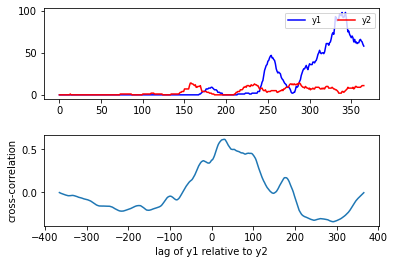

In [21]:
fig, axs = plt.subplots(nrows=2)
fig.subplots_adjust(hspace=0.4)
ax = axs[0]
ax.plot(baires.get(), 'b', label='y1')
ax.plot(caba.get(), 'r', label='y2')
ax.legend(loc='upper right', fontsize='small', ncol=2)

ax = axs[1]
ax.plot(lags.get(), ccor.get())
ax.set_ylabel('cross-correlation')
ax.set_xlabel('lag of y1 relative to y2')

maxlag = lags[cp.argmax(ccor)]
print("max correlation is %f" % cp.max(ccor))
print("max correlation is at lag %d" % maxlag)

# Ahora, lo hacemos en serio, tipo todas las provincias contra todas las provincias, y guardamos los resultados

In [22]:
localidades_lagmax = cp.zeros(shape=(rows,rows))
localidades_corrmax = cp.zeros(shape=(rows,rows))
npts = cols
lags = cp.arange(-npts + 1, npts)
i = 0
while i < rows:
    j = 0
    prov_tmp_1 = time_series_ac[i,:-10]
    while j < rows:
        prov_tmp_2 = time_series_ac[j,:-10]
        ccov = np.correlate(prov_tmp_1  - prov_tmp_1 .mean(), prov_tmp_2 - prov_tmp_2.mean(), mode='full')
        ccor = ccov / (npts * prov_tmp_1 .std() * prov_tmp_2.std())
        localidades_lagmax[i,j] = lags[cp.argmax(ccor)]
        localidades_corrmax[i,j] = cp.max(ccor)
        j = j + 1
    i = i +1

In [23]:
localidades_lagmax

array([[-10.,  21.,  -2., ...,  53.,  44., -31.],
       [-41., -10., -49., ..., -10., -11., -87.],
       [-18.,  29., -10., ...,  56.,  29., -50.],
       ...,
       [-73., -10., -76., ..., -10., -25., -81.],
       [-64.,  -9., -49., ...,   5., -10., -85.],
       [ 11.,  67.,  30., ...,  61.,  65., -10.]])

In [24]:
localidades_corrmax

array([[0.97340426, 0.60085306, 0.74431014, ..., 0.82896273, 0.55202079,
        0.48042489],
       [0.60085306, 0.97340426, 0.54410434, ..., 0.6472718 , 0.38447715,
        0.43208313],
       [0.74431014, 0.54410434, 0.97340426, ..., 0.68571187, 0.76647509,
        0.6296741 ],
       ...,
       [0.82896273, 0.6472718 , 0.68571187, ..., 0.97340426, 0.3834976 ,
        0.38995889],
       [0.55202079, 0.38447715, 0.76647509, ..., 0.3834976 , 0.97340426,
        0.68506988],
       [0.48042489, 0.43208313, 0.6296741 , ..., 0.38995889, 0.68506988,
        0.97340426]])